In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import PIL, cv2, os, imghdr

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers

import tensorflow_hub as hub

from tensorflow.keras.applications.vgg16 import preprocess_input

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_DETERMINISTIC_OPS'] = '1'

2024-02-11 23:36:39.148407: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-11 23:36:43.218325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 23:36:43.218407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 23:36:43.567200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 23:36:44.500653: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-11 23:36:44.503690: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [7]:
np.random.seed(42)
tf.random.set_seed(42)
data_dir = 'datasets/flower_photos' 

<h3><center>Flowers classification</center></h3>

## Table of Contents
* [Project objectives](#section_1_1)
* [Data source](#section_2_1)
* [Data preparation](#section_3_1)
* [Experiment 1 - Custom CNN ](#section_5_1)
    * [Configuration](#section_5_2)
    * [Evaluation and tests](#section_5_3)
    * [Conclusions](#section_5_4)
* [Experiment 2 - Residual neural network](#section_6_1)
    * [Configuration](#section_6_2)
    * [Evaluation and tests](#section_6_3)
    * [Conclusions](#section_6_4)
* [Experiment 3 - Transfer learning - Mobilenet V2](#section_7_1)
    * [Configuration](#section_7_2)
    * [Evaluation and tests](#section_7_3)
    * [Conclusions](#section_7_4)
* [Resources](#section_8_1)

### Project objectives: <a class="anchor" id="section_1_1"></a>
* Find appropriate data to prepare flowers classification model
* Analyze the available data and prepare balanced dataset
* Perform a few experiments and select the best performing model
* Additional objectives:
    - Avoid using extra modules if possible
    - Organize the code in reusable chunks
    - Evaluate each model by measuring its loss, accuracy, f1, precision and recall 
    - Present the training process visually 
    - Avoid the overfit with different techniques

### Data source: <a class="anchor" id="section_2_1"></a>
<a href="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz">The original data </a>is stored on GoogleApis Storage. It contains images of flowers from 5 different categories. What is important for this dataset is that it is highly imbalanced. For the purpose of this project, we will do the following:
 - Download the images
 - Replace one of the existing classes with an extra class. We want to make things a little more interesting
 - The images for the extra class will be downloaded from Google Images manually
 - To make sure the dataset is balanced, we will create extra images using augmentation technique.The augmentation logic and code is in the other notebook called <b>Image generator.ipynb</b>

After those manipulation we will end up with 5 categories with approximetely 1000 images in each.</br>
<b>N.B.</b> - The archieve does not contain the training set. It can be reviewed <a href="https://github.com/leonidgorunov2020/Complete_Projects/tree/main/Deep%20Learning">here</a>.

### Data preparation: <a class="anchor" id="section_3_1"></a>

Since we inject an additional set of images, we want to iterate over all of the items and make sure they are indeed images. 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [5]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

The following are functions designed to:
 - Prepare a dataset from images in a specific folder
 - Prepare train, validation and test sets manually
 - Apply augmentation
 - Set custom learning rate for the models that will utilize this technique

In [5]:
def generate_image_data(img_x, img_y, data_dir, seed=42):
    '''
    Based of X, y and image location, returns dataset
    '''
    tf.random.set_seed(seed)
    data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(img_x, img_y))
    data = data.map(lambda x, y: (x/255, y))
    return data

def generate_train_val_test(data, seed=42):
    '''
    Returns train, val, test sets 
    '''
    tf.random.set_seed(seed)
    train_size = int(len(data) * 0.7)
    val_size = int(len(data) * 0.1)
    test_size = int(len(data) * 0.2)
    
    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size + val_size).take(test_size)
    return train, val, test

def apply_augmentation(img_x, img_y, factor, seed=42):
    '''
    Applies augmentation based on flip, rotation and zoom
    '''
    tf.random.set_seed(seed)
    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_x, img_y, 3)),
            layers.experimental.preprocessing.RandomRotation(factor),
            layers.experimental.preprocessing.RandomZoom(factor),
        ]
    )
    return data_augmentation

def lr_scheduler(epoch, lr):
    '''
    Returns updated learning rate
    '''
    if epoch < 7:
        return lr
    return lr * tf.math.exp(-0.1)

# Experiment 1 - Custom CNN <a class="anchor" id="section_5_1"></a>

<b>Info:</b> Convolutional neural networks (CNNs) are developed in a way to understand visual patterns by breaking down images into smaller pieces and analyzing them systematically. CNNs use small filters or 'convolutions' to scan over an image, picking up important features like edges, shapes, and textures. These filters slide across the image, capturing information and creating a map of features.

As the information moves through the layers, these features are combined and analyzed in deeper layers, allowing the network to recognize more complex patterns and objects. This process is repeated multiple times, with each layer learning to detect increasingly abstract and high-level features.

The general idea of CNNs is to be able to accurately predict what is shown on a given image.

Let's start with:
 - Setting up base image size
 - Generate data
 - Generate train, validation and test sets
 - Apply augmentation

In [3]:
#Set base size for the images
img_dim = 128

In [8]:
#Generate data
data = generate_image_data(img_dim, img_dim, data_dir, seed=42)

Found 5179 files belonging to 5 classes.


In [9]:
#Generate train, validation and test sets
train, val, test = generate_train_val_test(data, seed=42)

In [10]:
#Apply data augmentation
data_augmentation = apply_augmentation(img_dim, img_dim, 0.1, seed=42)

In [11]:
#Set up tf logs dit
logdir='logs'

In [19]:
#Set up callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [54]:
#Clean keras backend
tf.keras.backend.clear_session()

In [55]:
#Set up basic training params
num_classes = 5
batch_size = 32
epochs = 20
tf.random.set_seed(42)

## Configuration  <a class="anchor" id="section_5_2"></a>
 - 3 convolutional layers with respectively 64,32 and 16 filters
 - Flattening layer
 - 2 fully connected layers with 64 and 32 neurons and dropouts to control the learning process
 - The model utilizes EarlyStopping and custom starting learning rate

In [56]:
lr_schedule = LearningRateScheduler(lr_scheduler)

model = Sequential([
    data_augmentation,

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    
    layers.Flatten(),

    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.4),
#     layers.Dense(16, activation='relu'),

    
    layers.Dense(num_classes)
])

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist_aug = model.fit(train,  epochs=epochs, batch_size = batch_size, validation_data=val,\
                     callbacks=[tensorboard_callback, early_stopping])


Epoch 1/20
113/113 [==============================] - 75s 647ms/step - loss: 1.4972 - accuracy: 0.3285 - val_loss: 1.2624 - val_accuracy: 0.4902
Epoch 2/20
113/113 [==============================] - 72s 639ms/step - loss: 1.2817 - accuracy: 0.4748 - val_loss: 1.1750 - val_accuracy: 0.5879
Epoch 3/20
113/113 [==============================] - 72s 632ms/step - loss: 1.1889 - accuracy: 0.5382 - val_loss: 1.0345 - val_accuracy: 0.6250
Epoch 4/20
113/113 [==============================] - 72s 633ms/step - loss: 1.0816 - accuracy: 0.5802 - val_loss: 0.9718 - val_accuracy: 0.6230
Epoch 5/20
113/113 [==============================] - 71s 628ms/step - loss: 0.9889 - accuracy: 0.6305 - val_loss: 0.9019 - val_accuracy: 0.6816
Epoch 6/20
113/113 [==============================] - 71s 630ms/step - loss: 0.9543 - accuracy: 0.6394 - val_loss: 0.8260 - val_accuracy: 0.7148
Epoch 7/20
113/113 [==============================] - 71s 630ms/step - loss: 0.8605 - accuracy: 0.6861 - val_loss: 0.8303 - val_ac

## Evaluation and tests  <a class="anchor" id="section_5_3"></a>

In [67]:
model.evaluate(test)

32/32 [==============================] - 8s 150ms/step - loss: 0.7033 - accuracy: 0.7500


[0.7033061385154724, 0.75]

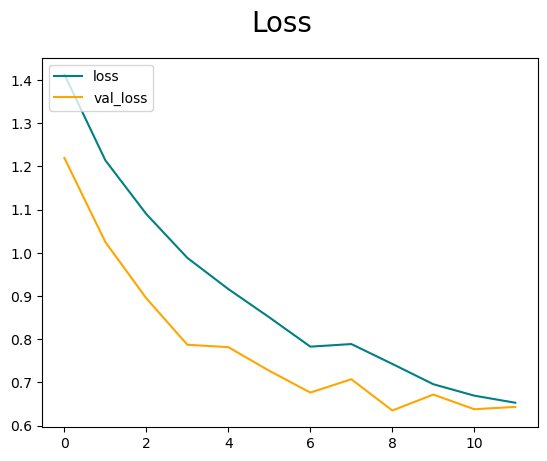

In [68]:
fig = plt.figure()
plt.plot(hist_aug.history['loss'], color='teal', label='loss')
plt.plot(hist_aug.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

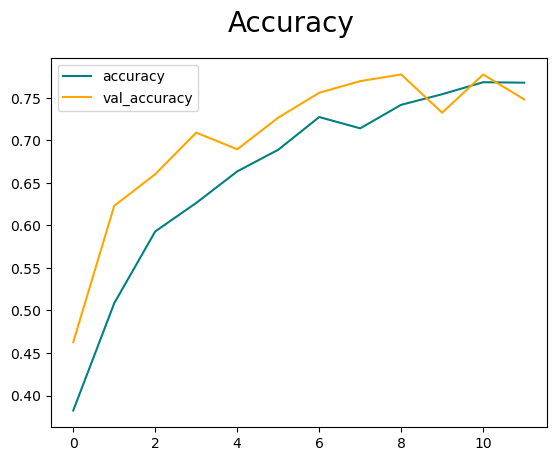

In [69]:
fig = plt.figure()
plt.plot(hist_aug.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_aug.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Here we are saving the model, the load it and test it with a custom image that is not part of the dataset.

In [70]:
model.save('saved_models/model_aug.keras')

In [91]:
loaded_model = load_model('saved_models/model_aug.keras')

In [92]:
image_path = './test_images/rose_1.jpeg'   
image = cv2.imread(image_path)
resized_image = cv2.resize(image, (128, 128))
resized_image = np.expand_dims(resized_image, axis=0)


In [93]:
preprocessed_image = preprocess_input(resized_image)
predictions = loaded_model.predict(preprocessed_image)

1/1 [==============================] - 0s 88ms/step


In [94]:
#Predictions are actually probabilities. Using argmax we take the highest one. Class 2 in this case is roses
np.argmax(predictions)

2

Now we check precision, recall and f1 and each one of the classes

In [97]:

class_names = [str(i) for i in range(5)]  
num_classes = len(class_names)

precision_metrics = [Precision() for _ in range(num_classes)]
recall_metrics = [Recall() for _ in range(num_classes)]

for batch in data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    
    for i in range(num_classes):
        class_label = i
        class_true = tf.cast(tf.equal(y, class_label), tf.float32)
        class_pred = tf.cast(tf.equal(tf.argmax(yhat, axis=1), class_label), tf.float32)

        precision_metrics[i].update_state(class_true, class_pred)
        recall_metrics[i].update_state(class_true, class_pred)

precision_results = [precision_metric.result().numpy() for precision_metric in precision_metrics]
recall_results = [recall_metric.result().numpy() for recall_metric in recall_metrics]

# Calculate F1 score for each class
f1_results = [2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
              for precision, recall in zip(precision_results, recall_results)]

print("Precision for each class:", precision_results)
print("Recall for each class:", recall_results)
print("F1 score for each class:", f1_results)

1/1 [==============================] - 0s 137ms/step
Precision for each class: [0.7869416, 0.74600357, 0.80156076, 0.77, 0.823638]
Recall for each class: [0.66505325, 0.76502734, 0.70490193, 0.9112426, 0.8796844]
F1 score for each class: [0.7208813866683481, 0.7553956681287586, 0.7501304291917663, 0.8346883013425596, 0.8507390976690072]


## Conclusions  <a class="anchor" id="section_5_4"></a>

In this experiment we have started with a little more parameters. The idea was to allow the model to capture more complex structures and this way achieve higher results. We see however, that around 70% accuracy, the model reached plato and could continue improving with the same steps. In the end early stopping technique kicked in and stopped the training process. It seems this situation happens because of the synthetically generated data we use during the training. 

The training process has been started with a bit higher initial learning rate. Dropouts in the dense layers were protecting the training process from overfit. This experiments shows that a little more complex CNN with appropriate Dropouts can achieve acceptable results on a small dataset

# Experiment 2 Resnet implementation <a class="anchor" id="section_6_1"></a>

In the following cell we:
 - Set the base image size
 - Generate data
 - Generate train, validation and test sets
 - Apply augmentation
 - Set up callbacks

In [ ]:
img_size = 128
data = generate_image_data(img_size, img_size, data_dir)
train, val, test = generate_train_val_test(data)
data_augmentation = apply_augmentation(img_size, img_size, 0.1)
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


Here we:
 - Clear keras backend
 - Set number of classes
 - Specify epochs
 - Set the residual block

In [224]:
tf.keras.backend.clear_session()

num_classes = 5
batch_size=32
epochs=30

In [229]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # First convolution
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = ReLU()(x)

    # Second convolution
    x = Conv2D(filters, kernel_size, padding='same')(x)

    # Adding the shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Initial Convolution
    x = layers.Conv2D(64, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)
    
    # 2nd Convolution
    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)
    
    # 3rd Convolution
    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = layers.ReLU()(x)

    # Residual Blocks
    x = residual_block(x, 32)



    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

resnet_model = build_resnet((img_size, img_size, 3), num_classes)


In [230]:
resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 64, 64, 64)           1792      ['sequential[42][0]']         
                                                                                                  
 re_lu_10 (ReLU)             (None, 64, 64, 64)           0         ['conv2d_10[0][0]']           
                                                                                            

## Configuration <a class="anchor" id="section_6_2"></a>

Now we:
 - Set optimized
 - Define early stopping
 - Compile and fit the model

In [231]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


restnet_hist = resnet_model.fit(train, validation_data=val, \
                                epochs=epochs, callbacks=[tensorboard_callback, early_stop])

Epoch 1/30
113/113 [==============================] - 26s 218ms/step - loss: 1.4481 - accuracy: 0.3482 - val_loss: 1.2563 - val_accuracy: 0.4727
Epoch 2/30
113/113 [==============================] - 25s 216ms/step - loss: 1.1625 - accuracy: 0.5335 - val_loss: 1.0586 - val_accuracy: 0.5918
Epoch 3/30
113/113 [==============================] - 25s 217ms/step - loss: 1.0365 - accuracy: 0.6114 - val_loss: 1.0146 - val_accuracy: 0.5977
Epoch 4/30
113/113 [==============================] - 25s 217ms/step - loss: 0.9148 - accuracy: 0.6629 - val_loss: 0.8234 - val_accuracy: 0.6816
Epoch 5/30
113/113 [==============================] - 25s 218ms/step - loss: 0.8478 - accuracy: 0.6883 - val_loss: 0.7970 - val_accuracy: 0.7285
Epoch 6/30
113/113 [==============================] - 24s 215ms/step - loss: 0.7685 - accuracy: 0.7188 - val_loss: 0.6920 - val_accuracy: 0.7402
Epoch 7/30
113/113 [==============================] - 25s 220ms/step - loss: 0.7254 - accuracy: 0.7364 - val_loss: 0.6818 - val_ac

## Resnet evaluation  <a class="anchor" id="section_6_3"></a>

In [232]:
resnet_model.evaluate(test)

32/32 [==============================] - 10s 181ms/step - loss: 0.6342 - accuracy: 0.7686


[0.6342321634292603, 0.7685546875]

In [233]:
model.save('saved_models/resnet_model.keras')

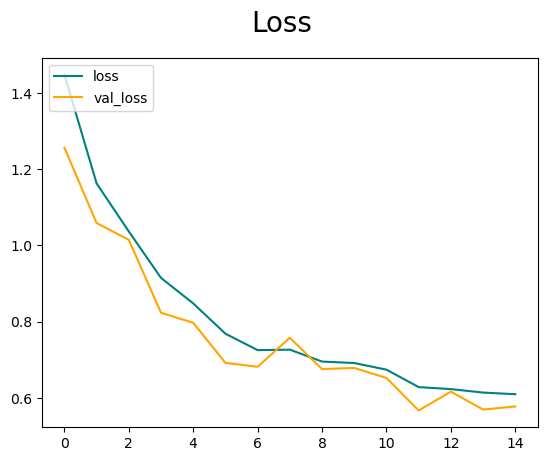

In [235]:
fig = plt.figure()
plt.plot(restnet_hist.history['loss'], color='teal', label='loss')
plt.plot(restnet_hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


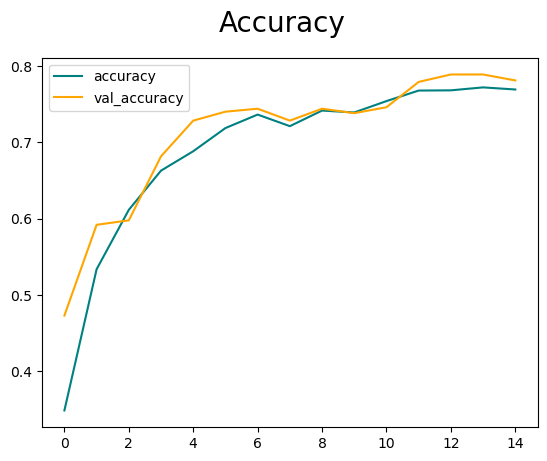

In [236]:

fig = plt.figure()
plt.plot(restnet_hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(restnet_hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Now we evaluate the achievments by measuring precision recall and f1 scores

In [239]:
model = resnet_model
class_names = [str(i) for i in range(5)]  
num_classes = len(class_names)

precision_metrics = [Precision() for _ in range(num_classes)]
recall_metrics = [Recall() for _ in range(num_classes)]

for batch in data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    
    for i in range(num_classes):
        class_label = i
        class_true = tf.cast(tf.equal(y, class_label), tf.float32)
        class_pred = tf.cast(tf.equal(tf.argmax(yhat, axis=1), class_label), tf.float32)

        precision_metrics[i].update_state(class_true, class_pred)
        recall_metrics[i].update_state(class_true, class_pred)

precision_results = [precision_metric.result().numpy() for precision_metric in precision_metrics]
recall_results = [recall_metric.result().numpy() for recall_metric in recall_metrics]

# Calculate F1 score for each class
f1_results = [2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
              for precision, recall in zip(precision_results, recall_results)]

print("Precision for each class:", precision_results)
print("Recall for each class:", recall_results)
print("F1 score for each class:", f1_results)

1/1 [==============================] - 0s 234ms/step
Precision for each class: [0.7127962, 0.7219882, 0.81670535, 0.82215744, 0.8499044]
Recall for each class: [0.72797674, 0.78051, 0.6901961, 0.83431953, 0.87672585]
F1 score for each class: [0.7203065013635521, 0.750109410857048, 0.7481402689037392, 0.8281938170647034, 0.8631068272187342]


## Conclusions  <a class="anchor" id="section_6_4"></a>

In this second experiment we tested the opposite - smaller number of parameters with higher learning rate. We wanted to check if a simpler model with ability to deal with vanishing gradients would work better with a relatively small dataset. 

The results are identical. Pretty much the same number of epochs and plato around 70% before early stopping technique to kick in. Looking at the training loss curve however, we see it smoother than the same parameter of the first experiment which makes me think that the second experiment is a bit more successful. 

# Experiment 3 - Transfer Learning Mobilenet v2 <a class="anchor" id="section_7_1"></a>

<b>Info:</b>Transfer learning is a powerful technique in deep learning where knowledge gained from training on one task is copies / transferred to another related task. In reality, instead of starting the learning process from scratch every time , we begin with a model that has already been trained on a large dataset for a similar task.

As we will see transfer learning can be incredibly beneficial in scenarios where we have limited data for the task we want to solve, as it allows us to use previously gained knowledge.

In this experiment, we will obtain a trained model, remove its classification part and train it for our task.

We obtain the module and remove it classification part

In [26]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [27]:
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)


Here we set appropriate image size and generate a data set. The process includes the generation of train, validation and test sets

In [28]:
img_size = 224
data = generate_image_data(img_size, img_size, data_dir)
train, val, test = generate_train_val_test(data)

Found 5179 files belonging to 5 classes.


We define base params and model

In [33]:
num_of_classes = 5
epochs = 5
batch_size = 16

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Configuration <a class="anchor" id="section_7_2"></a>

Now we:
 - Clean keras backend
 - Set up callbacks
 - Define optimizer and eaery stopping
 - Compile and fit the model

In [30]:
tf.keras.backend.clear_session()

In [31]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

mobilenet_v2 = model.fit(train,  epochs=epochs, batch_size = batch_size, validation_data=val,\
                     callbacks=[tensorboard_callback, early_stopping])

Epoch 1/5
113/113 [==============================] - 127s 623ms/step - loss: 0.4963 - accuracy: 0.8222 - val_loss: 0.2397 - val_accuracy: 0.9199
Epoch 2/5
113/113 [==============================] - 68s 601ms/step - loss: 0.2117 - accuracy: 0.9339 - val_loss: 0.1756 - val_accuracy: 0.9551
Epoch 3/5
113/113 [==============================] - 69s 608ms/step - loss: 0.1602 - accuracy: 0.9497 - val_loss: 0.1712 - val_accuracy: 0.9414
Epoch 4/5
113/113 [==============================] - 69s 605ms/step - loss: 0.1206 - accuracy: 0.9635 - val_loss: 0.1210 - val_accuracy: 0.9668
Epoch 5/5
113/113 [==============================] - 67s 592ms/step - loss: 0.0956 - accuracy: 0.9751 - val_loss: 0.0961 - val_accuracy: 0.9766


## Mobilenet_v2 evaluation <a class="anchor" id="section_7_3"></a>

In [35]:
model.save('saved_models/mobilenet_v2.keras')

In [37]:
model.evaluate(test)

32/32 [==============================] - 20s 485ms/step - loss: 0.1689 - accuracy: 0.9385


[0.1688862144947052, 0.9384765625]

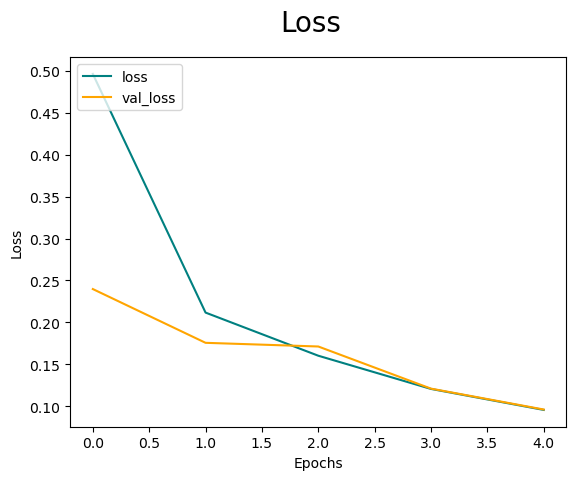

In [38]:
fig = plt.figure()
plt.plot(mobilenet_v2.history['loss'], color='teal', label='loss')
plt.plot(mobilenet_v2.history['val_loss'], color='orange', label='val_loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

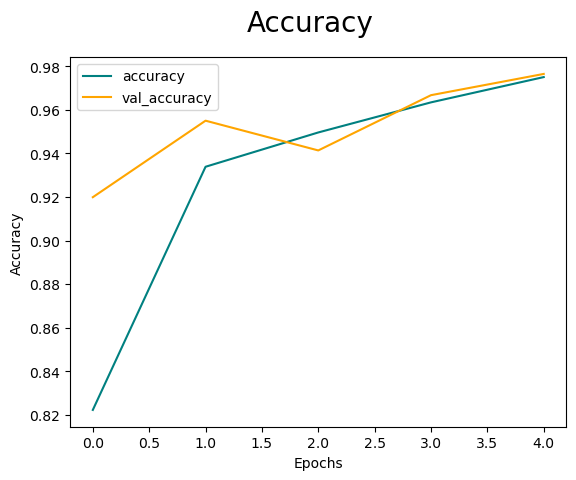

In [39]:
fig = plt.figure()
plt.plot(mobilenet_v2.history['accuracy'], color='teal', label='accuracy')
plt.plot(mobilenet_v2.history['val_accuracy'], color='orange', label='val_accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Conclusions  <a class="anchor" id="section_7_4"></a>

MobileNet v2 was intentionally selected as we have limited computational resources. Since it has been trained with over 1.4M images, it significantly outperforms the previous two models. In just 5 epochs it reached almost 94% which according to research on the matter is quite a good result.  It looks like custom learning rate and early stopping were not actually needed to control the overfit. 

### Project objectives: <a class="anchor" id="section_1_1"></a>

<b>CNN</b>
 - https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/
 - https://datascientest.com/en/unveiling-the-secrets-of-the-vgg-model-a-deep-dive-with-daniel
 - https://datagen.tech/guides/computer-vision/vgg16/
 - https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918</br>

<b>ResNet</b>
 - https://viso.ai/deep-learning/resnet-residual-neural-network/
 - https://content.iospress.com/articles/journal-of-intelligent-and-fuzzy-systems/ifs210925
 - https://ieeexplore.ieee.org/document/8517574
 - https://www.ikomia.ai/blog/mastering-resnet-deep-learning-image-recognitiontransferl

<b>Transfer learning</b>
 - https://www.v7labs.com/blog/transfer-learning-guide
 - https://www.sciencedirect.com/topics/computer-science/transfer-learning
 - https://paperswithcode.com/sota/transfer-learning-on-office-home

<b>Other</b>
 - https://www.tensorflow.org/tutorials
 - https://www.tensorflow.org/model_optimization
 - https://www.softserveinc.com/en-us/blog/deep-learning-model-compression-and-optimization